The lower limit of $T^{0\nu\beta\beta}_{1/2}$ is given by
$$ S(T^{0\nu\beta\beta}_{1/2})  = \text{log}(2) \cdot \epsilon_s \cdot \frac{t \cdot N_0}{S(b)}$$

In [1]:
import os
import time
import numpy  as np
import pandas as pd

from invisible_cities.core.system_of_units import kg, dalton, year, day, mBq, m3, mm, cm, m, s

%matplotlib notebook
import matplotlib.pyplot as plt

# os.sys.path.append("/Users/gonzalo/NEXT/pybbsens/")
# from pybbsens.conflimits import FeldmanCousins

In [2]:
Ul_df = pd.read_csv("./feldman_cousins_db/fc_upper_lims.csv", index_col=0)
# change index and column format
Ul_df.index   = np.round(Ul_df.index.to_list(), decimals=1)
Ul_df.columns = np.array([float(exp) for exp in Ul_df.columns.to_list()])

In [3]:
enrichment    = 0.9
signal_eff    = 0.2122
signal_eff    = 0.175
xenon_density = 78.949 * kg/m3
volume        = np.pi*(490*mm)**2*1200*mm
xenon_mass    = (xenon_density * volume)
N0 = enrichment * (xenon_mass/(136. * dalton))

background_rate = 3.7
background_rate = 0.83

def T12_90(t, c):
    Sb = Ul_df.loc[c, t]
    return (np.log(2.) * t * signal_eff * N0) / Sb

In [4]:
exposures        = Ul_df.columns.to_numpy()
background_rates = Ul_df.index  .to_numpy()

<IPython.core.display.Javascript object>


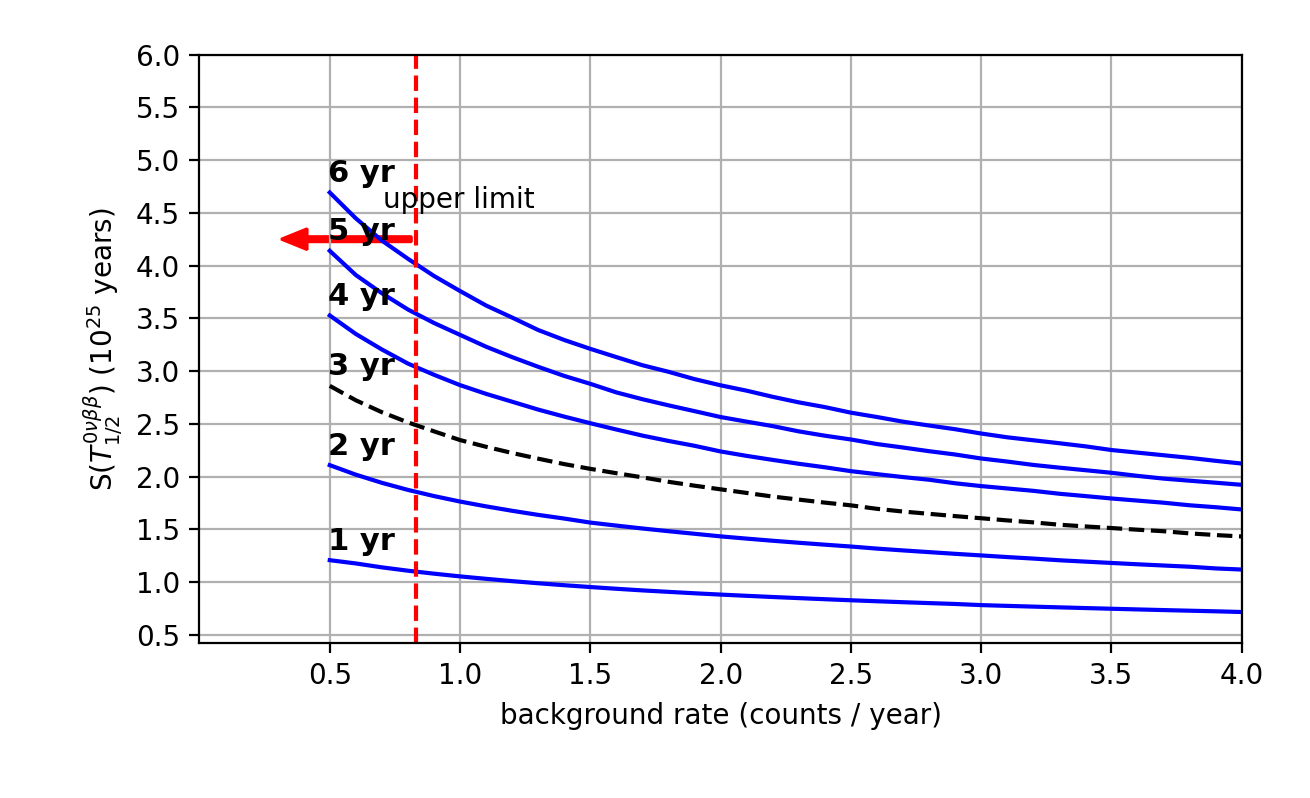

In [12]:
plt.figure(figsize=[5, 3])

for t in exposures[::2]:
    
    t12 = T12_90(t, background_rates).values/1e25
    
    color = "b"
    linestyle = "-"
    if t == 3: color="k"; linestyle = "--"
    plt.plot(background_rates, t12, color=color, linestyle=linestyle)
    
    plt.annotate( f"{int(t)} yr", xy    =(background_rates[0]*0.90, t12[0])
                                , xytext=(background_rates[0]*0.99, t12[0]+0.1)
                                , fontsize=11, weight='bold')
# background limit
plt.axvline(background_rate, linestyle="--", color="r", label="current upper limit")
plt.arrow( x=background_rate*0.98, y=4.25, dx=-0.4, dy=0
         , width=0.05, head_width=0.2, head_length=0.1, color="r"
         , joinstyle="bevel")

plt.annotate( "upper limit", xy    =(background_rate*0.85, 4.55)
                       , xytext=(background_rate*0.85, 4.55))

# x
plt.xticks(np.arange(0.5, 4.5, 0.5))
plt.xlim([0, 4])
plt.xlabel(r"background rate (counts / year)")

# y
plt.yticks(np.arange(0.5, 6.5, 0.5))
plt.ylabel(r"S($T^{0\nu\beta\beta}_{1/2}$) ($10^{25}$ years)")

plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


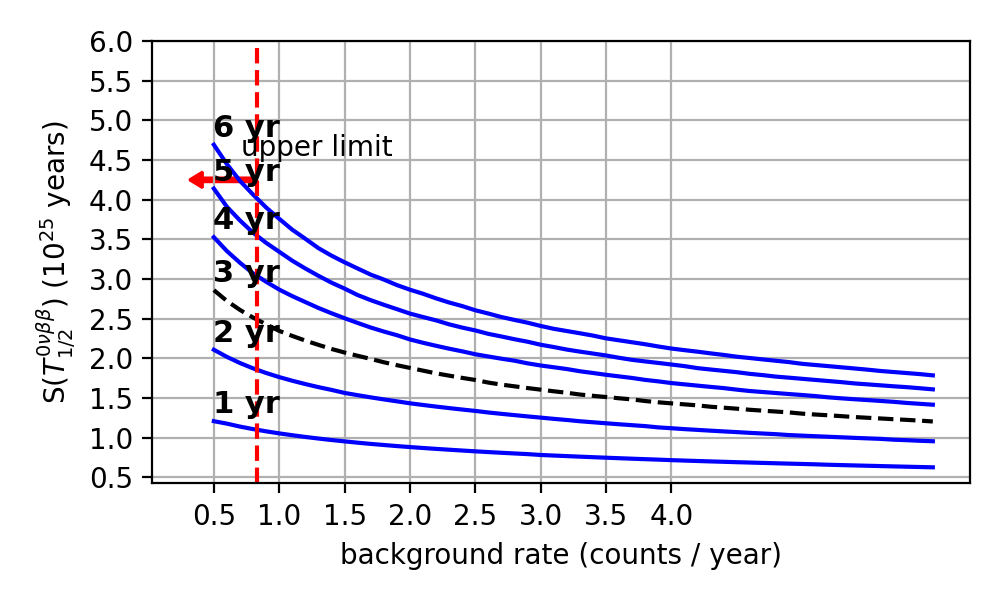

In [6]:
plt.figure(figsize=[5, 3])

for t in exposures[::2]:
    
    t12 = T12_90(t, background_rates).values/1e25
    
    color = "b"
    linestyle = "-"
    if t == 3: color="k"; linestyle = "--"
    plt.plot(background_rates, t12, color=color, linestyle=linestyle)
    
    plt.annotate( f"{int(t)} yr", xy    =(background_rates[0]*0.90, t12[0])
                                , xytext=(background_rates[0]*0.99, t12[0]+0.1)
                                , fontsize=11, weight='bold')
# background limit
plt.axvline(background_rate, linestyle="--", color="r", label="current upper limit")
plt.arrow( x=background_rate*0.98, y=4.25, dx=-0.4, dy=0
         , width=0.05, head_width=0.2, head_length=0.1, color="r"
         , joinstyle="bevel")

plt.annotate( "upper limit", xy    =(background_rate*0.85, 4.55)
                       , xytext=(background_rate*0.85, 4.55))

# x
plt.xticks(np.arange(0.5, 4.5, 0.5))
plt.xlabel(r"background rate (counts / year)")

# y
plt.yticks(np.arange(0.5, 6.5, 0.5))
plt.ylabel(r"S($T^{0\nu\beta\beta}_{1/2}$) ($10^{25}$ years)")

plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


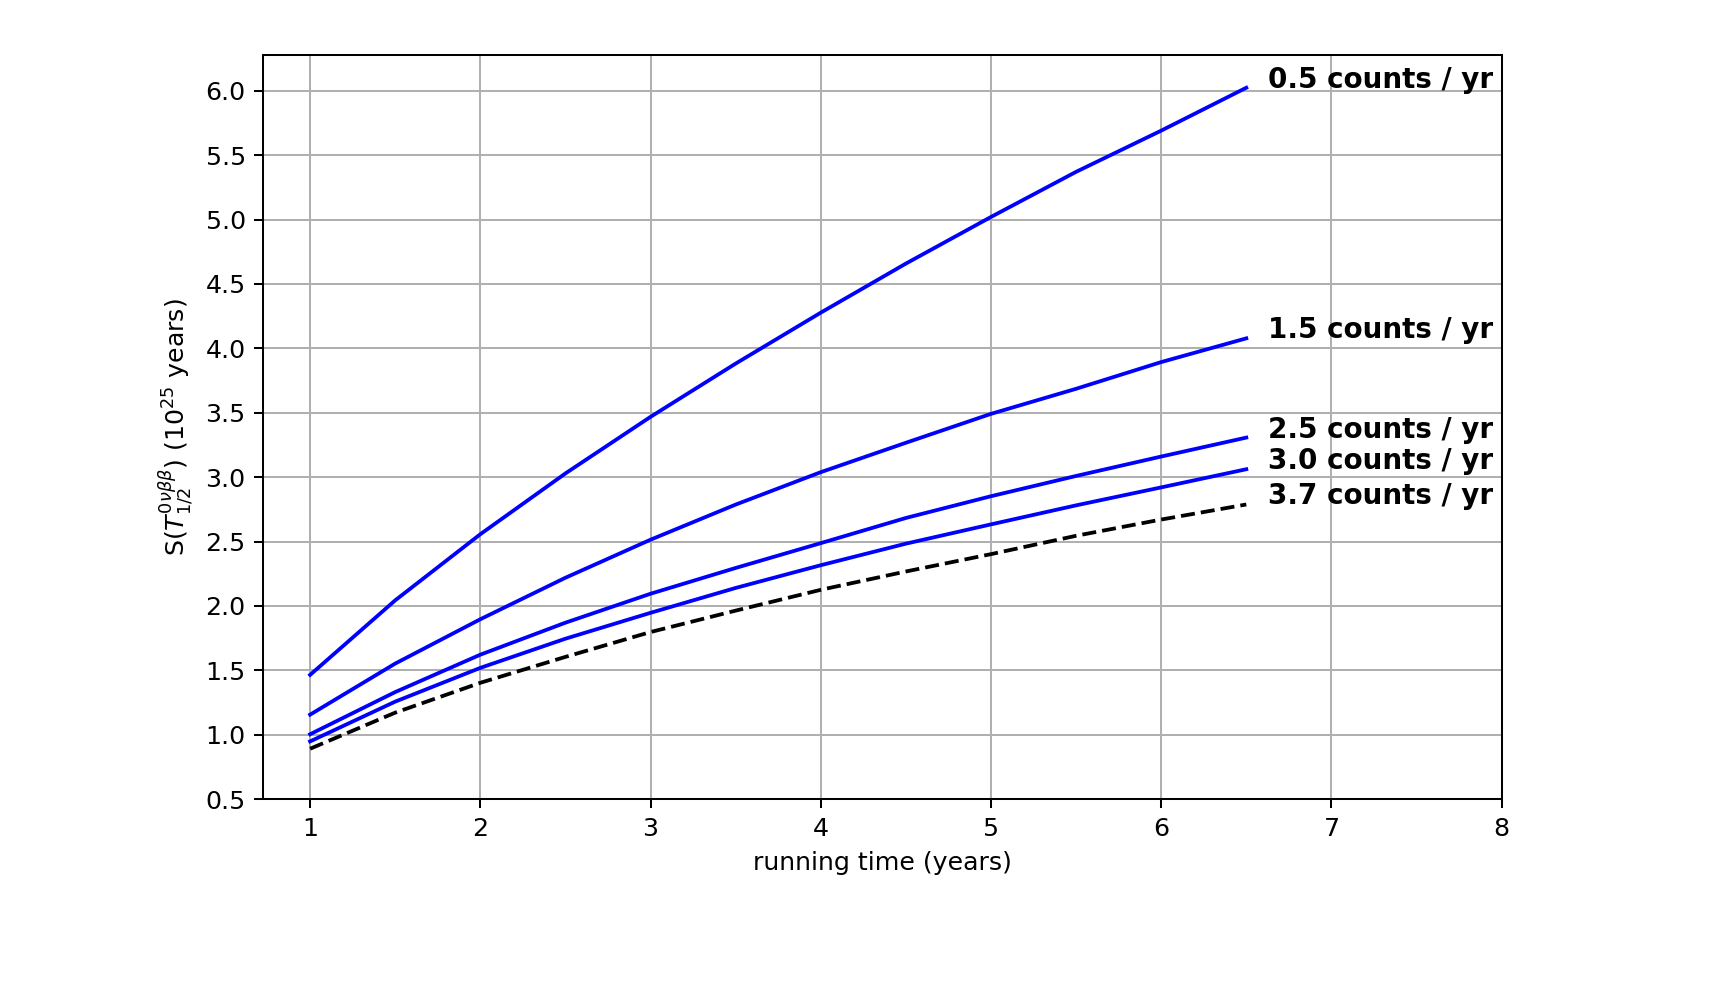

In [50]:
plt.figure(figsize=[5, 3])

background_rates = np.array([0.5, 1.5, 2.5, 3.0, 3.7])

for b in background_rates:
    t12 = T12_90(exposures, b).values/1e25
    
    color = "b"
    linestyle = "-"
    if b == 3.7: color="k"; linestyle = "--"
    plt.plot(exposures, t12, color=color, linestyle=linestyle)
    
    plt.annotate( f"{b} " + r"counts / yr", xy    =(exposures[-1]*0.90, t12[-1])
                                       , xytext=(exposures[-1]*1.02, t12[-1])
                                       , fontsize=11, weight='bold')
# background limit
# plt.axvline(background_rate, linestyle="--", color="r", label="current upper limit")
# plt.arrow( x=background_rate*0.98, y=4.25, dx=-0.4, dy=0
#          , width=0.05, head_width=0.2, head_length=0.1, color="r"
#          , joinstyle="bevel")

# plt.annotate( "bkg lim", xy    =(background_rate*0.85, 4.50)
#                        , xytext=(background_rate*0.85, 4.50))

# x
plt.xticks(np.arange(1, 9, 1))
plt.xlabel(r"running time (years)")

# y
plt.yticks(np.arange(0.5, 6.5, 0.5))
plt.ylabel(r"S($T^{0\nu\beta\beta}_{1/2}$) ($10^{25}$ years)")

plt.grid()
plt.tight_layout()

In [54]:
enrichment    = 0.9
signal_eff    = 0.2122
xenon_density = 78.949 * kg/m3
volume        = np.pi*(450*mm)**2*1160*mm
xenon_mass    = (xenon_density * volume)
N0 = enrichment * (xenon_mass/(136. * dalton))

In [55]:
xenon_mass/kg

58.2612130661004

In [21]:
@np.vectorize
def mean_upper_limit(b, cl=90):
    fc = FeldmanCousins(cl)
    return fc.AverageUpperLimit(b)

In [9]:
signal_eff = 0.2122
t = 3. # exposure (years)

background_rates = np.arange(0.5, 4.5, 0.25)

t0 = time.time()

b  = background_rates * t
Sb = mean_upper_limit(b, 90)

print("Processing time (min):", (time.time()-t0)/60)

Processing time (min): 1.429176966349284


<IPython.core.display.Javascript object>


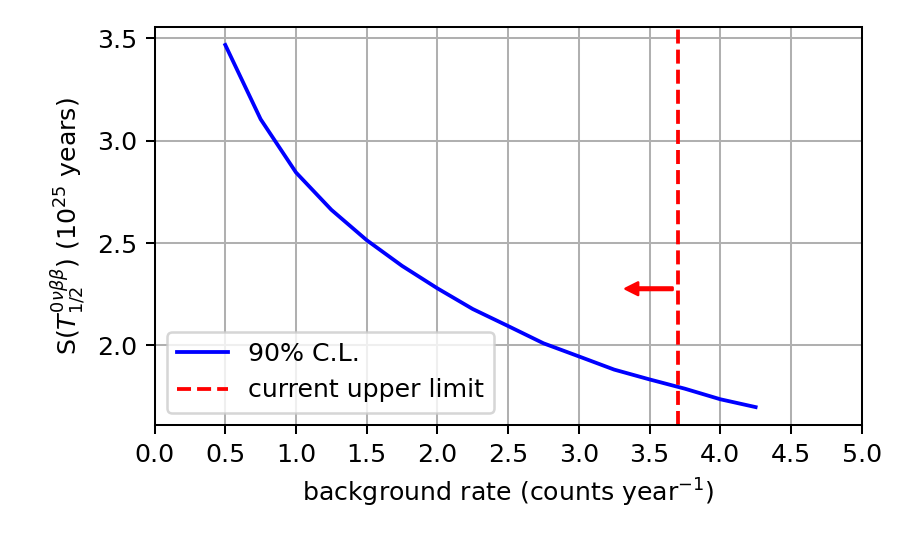

In [11]:
# plot
plt.figure(figsize=[5, 3])

# alpha = 1.64 # CL 90
# T12 = np.log(2) * t * signal_eff * N0 / (np.sqrt(background_rate * t) * alpha)
# plt.plot(t, T12/1e25, color="crimson", label="approx")

# plt.plot(background_rates/1e-3, T12_90/1e25, color=   "blue", label="90% C.L.")
# plt.axvline((background_rate*conversion_factor)/1e-3, linestyle="--", color="r", label="current upper limit")
# plt.annotate( "", xy    =((background_rate*conversion_factor/1e-3)*0.90, np.mean(T12_90/1e25))
#             ,     xytext=((background_rate*conversion_factor/1e-3)*0.99, np.mean(T12_90/1e25))
#             , arrowprops=dict(width=1, headwidth=5, headlength=5, color="r"))


plt.plot(background_rates, T12_90/1e25, color=   "blue", label="90% C.L.")
plt.axvline(background_rate, linestyle="--", color="r", label="current upper limit")
plt.annotate( "", xy    =((background_rate)*0.90, np.mean(T12_90/1e25))
            ,     xytext=((background_rate)*0.99, np.mean(T12_90/1e25))
            , arrowprops=dict(width=1, headwidth=5, headlength=5, color="r"))


# x
#plt.xlabel(r"background rate ($10^{-3}$ counts keV$^{-1}$kg$^{-1}$year$^{-1}$)")
plt.xticks(np.arange(0, 5.5, 0.5))
plt.xlabel(r"background rate (counts year$^{-1}$)")

# y
plt.ylabel(r"S($T^{0\nu\beta\beta}_{1/2}$) ($10^{25}$ years)")

plt.grid()
plt.legend()
plt.tight_layout()

In [12]:
tmax = 6
t = np.arange(1, tmax+0.25, 0.25)

t0 = time.time()

T12_90 = np.log(2.) * t * signal_eff * N0 / mean_upper_limit(background_rate*t, 90)
T12_95 = np.log(2.) * t * signal_eff * N0 / mean_upper_limit(background_rate*t, 95)

print("Time (min):", (time.time()-t0)/60.)

Time (min): 5.431242088476817


In [14]:
# plot
plt.figure(figsize=[4, 3])

# alpha = 1.64 # CL 90
# T12 = np.log(2) * t * signal_eff * N0 / (np.sqrt(background_rate * t) * alpha)
# plt.plot(t, T12/1e25, color="crimson", label="approx")

plt.plot(t, T12_90/1e25, color=   "blue", label="90% C.L.")
plt.plot(t, T12_95/1e25, color="crimson", label="95% C.L.")

plt.xticks(np.arange(1., tmax+0.5, 0.5))
plt.yticks(np.arange(0.5, 2.5, 0.2))
plt.xlabel("exposure (years)")
plt.ylabel(r"$T^{0\nu\beta\beta}_{1/2}$ ($10^{25}$ years)")
plt.grid()
plt.legend()
plt.tight_layout()

OSError: [Errno 24] Too many open files: '/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/matplotlib/backends/web_backend/js/mpl.js'